In [3]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/user/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('logistic_regression_adv_lche329_RFT').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.classification import LogisticRegression

In [4]:
# Read in the CSV data.
data = spark.read.load('./Sales_data/sales_en.csv',format='csv',header='true',inferSchema = True)

In [5]:
# Print data schema.
data.printSchema()

# Print data columns.
data.columns

root
 |-- ID: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Sales Representative: string (nullable = true)
 |-- Hospital Name: string (nullable = true)
 |-- Hospital Attribute: string (nullable = true)
 |-- Hospital Code: string (nullable = true)
 |-- Purchasing Price: double (nullable = true)
 |-- Selling Price: double (nullable = true)
 |-- IMF: string (nullable = true)
 |-- Hospital Class: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Client Name: string (nullable = true)
 |-- Sales Volume: double (nullable = true)
 |-- Profits: double (nullable = true)
 |-- Satisfaction: string (nullable = true)



['ID',
 'Year',
 'Product Name',
 'Unit',
 'Region',
 'Sales Representative',
 'Hospital Name',
 'Hospital Attribute',
 'Hospital Code',
 'Purchasing Price',
 'Selling Price',
 'IMF',
 'Hospital Class',
 'Department',
 'Client Name',
 'Sales Volume',
 'Profits',
 'Satisfaction']

In [6]:
# Select a list of relevant columns. 
# Profits, for example, should not be celected
# As the target 'Satisfaction' derives from 'Profits'
my_cols = data.select(['Satisfaction',
 'Sales Representative',
 'Hospital Attribute',
 'Selling Price',
 'Hospital Class',
 'Department',
 'Sales Volume'])
my_cols.toPandas().isnull().sum()

Satisfaction            0
Sales Representative    0
Hospital Attribute      0
Selling Price           0
Hospital Class          0
Department              0
Sales Volume            0
dtype: int64

In [7]:
my_final_data = my_cols

In [8]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [9]:
# First create a string indexer (convert every string into a number, such as male = 0 and female = 1).
# A number will be assigned to every category in the column.
Sales_Representative_indexer = StringIndexer(inputCol='Sales Representative',outputCol='Sales_Representative_Index')

# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# This makes it easier to process when you have multiple classes.
Sales_Representative_encoder = OneHotEncoder(inputCol='Sales_Representative_Index',outputCol='Sales_Representative_Vec')

In [10]:
Hospital_Attribute_indexer = StringIndexer(inputCol='Hospital Attribute',outputCol='Hospital_Attribute_Index')
Hospital_Attribute_encoder = OneHotEncoder(inputCol='Hospital_Attribute_Index',outputCol='Hospital_Attribute_Vec')

In [11]:
Hospital_Class_indexer = StringIndexer(inputCol='Hospital Class',outputCol='Hospital_Class_Index')
Hospital_Class_encoder = OneHotEncoder(inputCol='Hospital_Class_Index',outputCol='Hospital_Class_Vec')

In [12]:
Department_indexer = StringIndexer(inputCol='Department',outputCol='Department_Index')
Department_encoder = OneHotEncoder(inputCol='Department_Index',outputCol='Department_Vec')

In [13]:
Satisfaction_indexer = StringIndexer(inputCol='Satisfaction',outputCol='Satisfaction_Index')
#Satisfaction_encoder = OneHotEncoder(inputCol='Satisfaction_Index',outputCol='Satisfaction_Vec')
my_final_data_indexed = Satisfaction_indexer.fit(my_final_data).transform(my_final_data)
my_final_data_indexed.printSchema()
my_final_data_indexed.toPandas()['Satisfaction_Index']

root
 |-- Satisfaction: string (nullable = true)
 |-- Sales Representative: string (nullable = true)
 |-- Hospital Attribute: string (nullable = true)
 |-- Selling Price: double (nullable = true)
 |-- Hospital Class: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Sales Volume: double (nullable = true)
 |-- Satisfaction_Index: double (nullable = true)



0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0
7        1.0
8        1.0
9        1.0
10       1.0
11       0.0
12       0.0
13       0.0
14       1.0
15       0.0
16       1.0
17       1.0
18       0.0
19       0.0
20       0.0
21       0.0
22       1.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
        ... 
40255    0.0
40256    0.0
40257    0.0
40258    0.0
40259    0.0
40260    0.0
40261    0.0
40262    0.0
40263    0.0
40264    0.0
40265    0.0
40266    0.0
40267    0.0
40268    1.0
40269    0.0
40270    0.0
40271    0.0
40272    0.0
40273    0.0
40274    0.0
40275    0.0
40276    0.0
40277    0.0
40278    0.0
40279    0.0
40280    0.0
40281    0.0
40282    0.0
40283    0.0
40284    0.0
Name: Satisfaction_Index, Length: 40285, dtype: float64

In [14]:
# Now we can assemble all of this as one vector in the features column.
assembler = VectorAssembler(inputCols=['Sales_Representative_Vec',
 'Hospital_Attribute_Vec',
 'Selling Price',
 'Hospital_Class_Vec',
 'Department_Vec',
 'Sales Volume'],outputCol='features')

In [15]:
#from pyspark.ml.classification import LogisticRegression
#from pyspark.ml.classification import DecisionTreeClassifier
#from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier

In [16]:
from pyspark.ml import Pipeline

In [17]:
#log_reg_sales = LogisticRegression(featuresCol='features',labelCol='Satisfaction_Index')
#log_reg_sales = DecisionTreeClassifier(featuresCol='features',labelCol='Satisfaction_Index')
#log_reg_sales = GBTClassifier(featuresCol='features',labelCol='Satisfaction_Index')
log_reg_sales = RandomForestClassifier(featuresCol='features',labelCol='Satisfaction_Index')

In [18]:
# Lists everything we want to do. Index data, encode data, assemble data and then pass in the actual model.
pipeline = Pipeline(stages=[Sales_Representative_indexer,Hospital_Attribute_indexer,Hospital_Class_indexer,Department_indexer,
                           Sales_Representative_encoder,Hospital_Attribute_encoder,Hospital_Class_encoder,Department_encoder,
                           assembler,log_reg_sales])

In [19]:
# Train/test split. 
train_sales_data, test_sales_data = my_final_data_indexed.randomSplit([0.7,0.3])

In [20]:
# Note pipeline. Call it as you would call a machine learning object.
fit_model = pipeline.fit(train_sales_data)

In [21]:
# Transform test data. 
results = fit_model.transform(test_sales_data)

In [22]:
# Evaluate the model using the binary classifer.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='Satisfaction_Index')

In [23]:
results.select('Satisfaction_Index','prediction').show()

+------------------+----------+
|Satisfaction_Index|prediction|
+------------------+----------+
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
+------------------+----------+
only showing top 20 rows



In [27]:
# We can then evaluate using AUC (area under the curve). AUC is linked to ROC.
AUC = my_eval.evaluate(results)

print("AUC(70% Training & 30% Testing) = ",AUC)



AUC(70% Training & 30% Testing) =  0.5


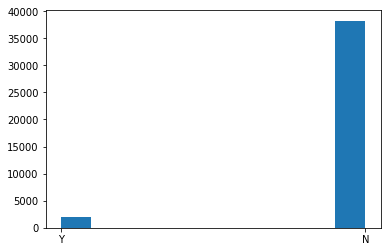

In [76]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert ‘Satisfaction’ to an array using Numpy and plot it using pyplot. 
SatisfactionArr = np.array(data.select('Satisfaction').collect())
plt.hist(SatisfactionArr)
plt.show()

In [28]:
#Performance Evaluation
totalResults = results.select('Satisfaction_Index','prediction')

correctResults = totalResults.filter(totalResults['Satisfaction_Index'] == totalResults['prediction'])

countTR = totalResults.count()
print("Correct: " + str(countTR))

countTC = correctResults.count()
print("Total Correct: " + str(countTC)) 

Correct: 11986
Total Correct: 11384
